### Проект Яндекс.Афиша

### Описание данных:

Данные предоставлены сервисом Яндекс.Афиша за период с июня 2017 по конец мая 2018 года.

Таблица visits (лог сервера с информацией о посещениях сайта):

* Uid — уникальный идентификатор пользователя
* Device — категория устройства пользователя
* Start Ts — дата и время начала сессии
* End Ts — дата и время окончания сессии
* Source Id — идентификатор рекламного источника, из которого пришел пользователь

Таблица orders (информация о заказах):
* Uid — уникальный id пользователя, который сделал заказ
* Buy Ts — дата и время заказа
* Revenue — выручка Яндекс.Афиши с этого заказа

Таблица costs (информация о затратах на маркетинг):
* source_id — идентификатор рекламного источника
* dt — дата
* costs — затраты на этот рекламный источник в этот день

Главная задача: помочь маркетологам оптимизировать маркетинговые затраты.

Подзадачи:

1. Выяснить как люди пользуются продуктом.
    - Посчитать сколько людей пользуются  продуктом в день, неделю, месяц.
    - Проанализировать как меняется среднее количество и продолжттельность сессии 
Сколько длится одна сессия?
Как часто люди возвращаются?
- сколько денег приносит каждый клиент
- 
План работы:

1. Анализ 


- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.

Вы изучите:

- когда они начинают покупать,
- сколько денег приносит каждый клиент
- когда клиент окупается.

### Шаг 1. Загрузка данных и подготовка их к анализу

In [1]:
# для начала загрузим библиотеки, необходимые для дальнейшей работы

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import math

In [2]:
# откорем и сохраним данные:

visits = pd.read_csv('https://code.s3.yandex.net/datasets/visits_log.csv')
orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders_log.csv')
costs = pd.read_csv('https://code.s3.yandex.net/datasets/costs.csv')

#### VISITS

In [3]:
# изучим каждую таблицу детально. Начнём с таблицы visits:

visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


Всего в таблице 5 столбцов и 359400 строк. Явных пропущенных значений нет. Типы данных не всегда соответствуют значениям. Дата начала и окончания сессии записана как object, её необходимо поменять на тип datetime. Значения колонок device и source id необходимо рассмотреть более детально. В стольбце Uid хранится тип данных 'unsigned integer', то есть значения не могут быть меньше нуля - это вполне логично.

In [4]:
# выведем 5 случайных строк из таблицы visits:

visits.sample(5)

,Device,End Ts,Source Id,Start Ts,Uid
284434,desktop,2018-01-09 15:46:00,4,2018-01-09 14:40:00,7975976584710135085
182270,desktop,2017-10-19 01:45:00,3,2017-10-19 01:37:00,16829616494926601012
97523,touch,2018-02-25 15:56:00,3,2018-02-25 15:55:00,14196729839369129841
348086,touch,2018-03-05 12:38:00,5,2018-03-05 12:34:00,15069978485039217790
127824,touch,2017-07-05 17:17:00,2,2017-07-05 17:02:00,3575527464767717809


In [5]:
# данные выглядят логично, смущает лишь отсутствие названий источников
# посмотрим сколько всего значений в этом столбце:

visits['Source Id'].value_counts()

4     101794
3      85610
5      66905
2      47626
1      34121
9      13277
10     10025
7         36
6          6
Name: Source Id, dtype: int64

В столбце 'Source Id' хранится информация о 9 рекламных источниках, с которых приходят пользователи. Исчисление прерывается на 7 и продолжается с 9, то есть идентификатор источника с цифрой 8 отсутствует. Для удобства и упорядоченности записей можем поменять идентификаторы: 10 на 9, а 9 на 8.

In [6]:
# изменим названия идентификаторов:

visits.loc[visits['Source Id']==9,'Source Id'] = 8
visits.loc[visits['Source Id']==10, 'Source Id'] = 9

In [7]:
# теперь проверим значения столбца 'Device':

visits['Device'].value_counts()

desktop    262567
touch       96833
Name: Device, dtype: int64

В столбце хранится итнформация об устройстве пользователей. Всего наблюдается два типа устройств: desktop и touch. 

In [8]:
# осталось поменять тип данных в столбцах с датами:

visits['End Ts'] = pd.to_datetime(visits['End Ts'])
visits['Start Ts'] = pd.to_datetime(visits['Start Ts'])


In [9]:
# данные в таблице visits упорядочены.
# для дальнейшего удобства с таблицей можно поменять названия столбцов, 
# привести все буквы к нижнему регистру, а пробел заменить нижним подчёркиванием:

visits.rename(columns={'Device':'device', 'End Ts': 'end_ts', 'Source Id': 'source_id', 'Start Ts': 'start_ts', 'Uid': 'uid'},inplace=True)


#### ORDERS

In [10]:
# получим общую информацию о таблице 'orders':

orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


В таблице 3 столбца и 50415 строк, пропущенных значений нет. В столбце 'Buy Ts' необходимо изменить тип данных на datetime. А также, для удобства, переименовать столбцы, приведя названия к нижнему региструи заменив пробел.

In [11]:
# поменяем название столбцов:

orders.rename(columns={'Buy Ts':'buy_ts', 'Revenue':'revenue', 'Uid':'uid'},inplace=True)

In [12]:
# изменим тип данных в столбце 'buy_ts':

orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])

In [13]:
# посмотрим на статистические характеристики в столбце 'revenue', хранящий информацию о выручке Яндекс.Афищи с заказа:

orders['revenue'].describe()

count    50415.000000
mean         4.999647
std         21.818359
min          0.000000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: revenue, dtype: float64

Стандартное отклонение равно 21.8, что говорит о разбросе значений в данных. Минимальное значение 0, это значит, что сюда попали не совсем корректные записи. Возможно были включены заказы, которые не состоялись по каким-то причинам, либо были подарочными от Яндекс.Афиши. Медианное значение равно 2.5, в то время как максимальное значение более чем в 1000 раз превышает медианное. Это говорит о выбросах, которые смещают среднее значение в большую сторону.

In [14]:
# проверим заказы, выручка от которых составляет 0 условных единиц:

orders[orders['revenue']== 0.000000].sample(10)

,buy_ts,revenue,uid
20807,2017-11-28 20:58:00,0.0,2636645662067512510
49040,2018-05-26 12:12:00,0.0,14872085179275033073
21938,2017-12-04 22:08:00,0.0,6538135401269860305
21220,2017-11-30 21:34:00,0.0,2037345392173160982
21386,2017-12-01 16:37:00,0.0,2037345392173160982
6995,2017-09-06 13:57:00,0.0,5603453646174104178
5863,2017-08-23 13:43:00,0.0,5603453646174104178
7104,2017-09-07 14:37:00,0.0,5603453646174104178
22014,2017-12-05 11:22:00,0.0,1879819502567241225
49234,2018-05-28 08:55:00,0.0,14973814017160376581


Всего таких строк - 51, что составляет 0.1% от общего числа строк в таблице. Также, даты таких заказов и уникальный идентификатор пользователя, совершившего данный заказ разнятся. Это позволяет заключить, что нулевые значения случайны. Следует более детально исследовать причины их появления, совместно с теми, кто эти данные выгружал. Ну а на данном этапе избавимся от этих строк.

In [15]:
# заменим нули на NAN, а затем выкинем пропущенные значения:

orders['revenue'] = orders['revenue'].replace(0.000000, np.nan)
orders = orders.dropna(subset=['revenue']).reset_index(drop=True)

#### COSTS

In [16]:
# получим общую информацию о таблице:

costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


В таблице "Costs" три столбца и 2542 записи. Необходимо проверить значение столбца 'source_id' и привести их к той же структуре как и в таблице  Visits. Тип данных в столбце dt сменим с object на datetime. И проверим значения в столбце costs. 

In [17]:
# Посмотрим на значения столбца  source_id:

costs['source_id'].value_counts()

5     364
9     363
3     363
1     363
10    363
4     363
2     363
Name: source_id, dtype: int64

Всего в столбце 7 идентификаторов рекламного источника. Идентификаторы 6 и 7 отсутствуют. Возможно, эти типы источников являются некомерческими формами реклами и поэтому не требуют денежных вложений. К примеру, это может быть такой тип источника как "сарафанное радио". Что касается источников 9 и 10, переименуем их в 8 и 9 соответственно.

In [18]:
costs[costs['source_id']==9]

,source_id,dt,costs
1816,9,2017-06-01,13.06
1817,9,2017-06-02,18.13
1818,9,2017-06-03,7.06
1819,9,2017-06-04,4.65
1820,9,2017-06-05,15.30
...,...,...,...
2174,9,2018-05-27,11.11
2175,9,2018-05-28,12.47
2176,9,2018-05-29,16.83
2177,9,2018-05-30,23.57


In [19]:
# изменим названия идентификаторов:

costs.loc[costs['source_id']==9,'source_id'] = 8
costs.loc[costs['source_id']==10, 'source_id'] = 9

In [20]:
# поменяем тип данных в столбце dt:

costs['dt'] = pd.to_datetime(costs['dt'])

In [21]:
# проверим статистические характеристики столбца costs:

costs['costs'].describe()

count    2542.000000
mean      129.477427
std       156.296628
min         0.540000
25%        21.945000
50%        77.295000
75%       170.065000
max      1788.280000
Name: costs, dtype: float64

Минимальное значение равно 0.54, медиана 77.29, а максимальное значение превышает медиану в 23 раза, что говорит о наличии выбросов.


In [22]:
# для удобства поменяем названия столбца с costs на 'spent':

costs.rename(columns={'costs':'spent'}, inplace=True)

### Шаг 2. Построим отчёты и посчитаем метрики

### Продукт

- Сколько людей пользуются в день, неделю, месяц?


In [23]:
# для ответа на данный вопрос, нам необходимо привести даты в нужный нам вид
# в таблице visits создадим cтолбцы, в которые извлечём дату, неделю и месяц:

visits['session_date'] = visits['start_ts'].dt.date
visits['session_week'] = visits['start_ts'].dt.week
visits['session_month'] = visits['start_ts'].dt.month
visits['session_year'] = visits['start_ts'].dt.year

In [24]:
# теперь мы можем посчитать метрики, сгрупировав данные по уникальным пользователям
# выведем среднее количество пользователей, пользующихся Яндекс Афишей в день

dau_mean = visits.groupby('session_date').agg({'uid':'nunique'}).mean()
dau_mean

uid    907.991758
dtype: float64

В среднем на сайт заходят 908 человек в день. Бывают дни когда зашёл лишь 1 человек, а бывает и более 3000 за день. 

In [25]:
# посчитаем среднее количество активных пользователей в неделю:

wau_mean = visits.groupby(['session_week','session_year']).agg({'uid':'nunique'}).mean()
wau_mean

uid    5716.245283
dtype: float64

В среднем 5716 человек в неделю посещают сайт.

In [26]:
# посчитаем количество активных пользователей в месяц:

mau_mean = visits.groupby(['session_month','session_year']).agg({'uid':'nunique'}).mean()
mau_mean

uid    23228.416667
dtype: float64

В месяц среднее количество активных пользователей составляет 23228 человек

Среднее количество уникальных пользователей за день, неделю, месяц мы узнали.
Теперь посмотрим как часто люди используют сайт.

In [27]:
# для этого будем использовать метрику sticky factor

sticky_factor = dau_mean / mau_mean * 100
sticky_factor

uid    3.90897
dtype: float64

Около 4% пользователей заходят на сайт снова в течении месяца с последней сессии. Это говорит о низкой вовлечённости пользователей. Но можно предположить, что это средний показатель для подобного сервиса, так как не все люди покупают билеты на развлекательные мероприятия каждый месяц.

- Сколько сессий в день?

In [28]:
# посчитаем сколько сессий в день приходится на человека.
# для этого посчитаем количество сессий за день и разделим на количество уникальных пользователей:

sessions_per_user = visits.groupby('session_date').agg({'uid':['count','nunique']})
sessions_per_user.columns = ['nsessions','nusers']
sessions_per_user['sessions_per_user'] = sessions_per_user['nsessions'] / sessions_per_user['nusers']
sessions_per_user

,nsessions,nusers,sessions_per_user
session_date,,,
2017-06-01,664,605,1.097521
2017-06-02,658,608,1.082237
2017-06-03,477,445,1.071910
2017-06-04,510,476,1.071429
2017-06-05,893,820,1.089024
...,...,...,...
2018-05-27,672,620,1.083871
2018-05-28,1156,1039,1.112608
2018-05-29,1035,948,1.091772


In [29]:
sessions_per_user['sessions_per_user'].mean()

1.082169644003972

В среднем на пользователя приходится по 1 сессии в день. То есть, продукт не используется регулярно. Но как было замечено ранее, для подобного сервиса это может быть показатель в пределах нормы.

- Сколько длится одна сессия?

In [30]:
# найдём среднюю продолжительность сессии
# для этого создадим в таблице visits столбец session_duration_sec,
# куда сохраним разницу в секундах между началом и окончанием для каждой сессии

visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds

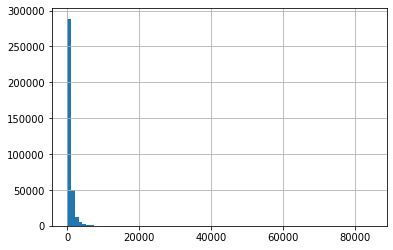

In [31]:
# проверим распределение, визуализируем значения столбца в виде гистограммы:

visits['session_duration_sec'].hist(bins=80)

In [32]:
# распределение далеко от нормального, поэтому вместо среднего посчитаем моду:

visits['session_duration_sec'].mode()

0    60
dtype: int64

В среднем сессия длится 60 секунды, или 1 минуту. Учитывая специфику сервиса, показатель не самый оптимальный, но могут также быть исключения в зависимости от контекста. В случае, если пользователь заходит на сайт с целью приобрести опредённый продукт, и до момента завршения процесса покупки проходит одна минута, это довольно быстро и значит хорошо, так как говорит об удобстве использования сервиса. Но, если пользователь зашёл на сайт без прдварительной цели покупки, вряд ли за минуту он успеет что-то выбрать и тем-более приобрести. Значит этот показатель не достаточно высок, и говорит о невовлечённости пользователей. Следовательно необходимо что-то менять.

- Как часто люди возвращаются на сайт?


Для ответа на поставленный вопрос, расчитаем метрику retention rate. Но прежде, нам необходимо разбить пользователей на когорты, и далее расчитать retention rate для каждой из них. 

In [33]:
# когорты будем создавать исходя из даты первого посещения сайта

first_visit_date_by_customers = visits.groupby('uid')['session_date'].min()
first_visit_date_by_customers.name = 'first_visit_date'
first_visit_date_by_customers.head()

uid
11863502262781     2018-03-01
49537067089222     2018-02-06
297729379853735    2017-06-07
313578113262317    2017-09-18
325320750514679    2017-09-30
Name: first_visit_date, dtype: object

In [34]:
# объединим таблицу visits и fitst_visit_date_by_cutomer:

visits = visits.merge(first_visit_date_by_customers, on='uid', how='left')


In [35]:
# выведем из столбцов first_visit_date и visit_date месяцы:

visits['first_visit_date'] = visits['first_visit_date'].astype('datetime64[M]')
visits['visit_month'] = visits['session_date'].astype('datetime64[M]')

In [36]:
# Когортой станет столбец first_visit_date - месяц, когда пользователь впервые зашёл на сайт.
# Теперь расчитаем для каждой строки lifetime пользователя в рамках когорты:

visits['cohort_lifetime'] = visits['visit_month'] - visits['first_visit_date']
visits['cohort_lifetime'] = visits['cohort_lifetime']/np.timedelta64(1,'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')

In [37]:
# выведем первые 5 строк таблицы и удостоверимся что все преобразования прошли успешно:

visits.head()

,device,end_ts,source_id,start_ts,uid,session_date,session_week,session_month,session_year,session_duration_sec,first_visit_date,visit_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,51,12,2017,1080,2017-12-01,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,8,2,2018,1680,2018-02-01,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,26,7,2017,0,2017-07-01,2017-07-01,0
3,desktop,2018-05-20 11:23:00,8,2018-05-20 10:59:00,16174680259334210214,2018-05-20,20,5,2018,1440,2018-03-01,2018-05-01,2
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,52,12,2017,0,2017-12-01,2017-12-01,0


In [38]:
# теперь сгруппируем данные по когорте и lifetime и посчитаем для каждой когорты
# количество активных пользователей на месяц:

cohorts = visits.groupby(['first_visit_date', 'cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
cohorts.head()

,first_visit_date,cohort_lifetime,uid
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909


In [39]:
# Чтоб найти Retention Rate, необходимо найти число пользователей изначально находящихся в когорте, а затем разделить на него
#  число пользователей в каждый последующий месяц. Для начала создадим таблицу, куда созраним начальное число пользователей в 
#  каждой когорте:

initial_users_count = cohorts[cohorts['cohort_lifetime']==0][['first_visit_date','uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_initial_users'})
initial_users_count 

,first_visit_date,cohort_initial_users
0,2017-06-01,13259
12,2017-07-01,13140
23,2017-08-01,10181
33,2017-09-01,16704
42,2017-10-01,25977
50,2017-11-01,27248
57,2017-12-01,25268
63,2018-01-01,22624
68,2018-02-01,22197
72,2018-03-01,20589


In [40]:
# объединим таблицы cohorts и initial_users_count
# и переименум столбец 'uid' в 'active_users':

cohorts = cohorts.merge(initial_users_count, on='first_visit_date')
cohorts = cohorts.rename(columns={'uid':'active_users'})

In [41]:
# теперь данные готовы для расчёта метрики Retention Rate.
# разделим количество активных пользователей за каждый месяц на исходное число пользователей в когорте:

cohorts['retention'] = cohorts['active_users'] / cohorts['cohort_initial_users']
cohorts.head()

,first_visit_date,cohort_lifetime,active_users,cohort_initial_users,retention
0,2017-06-01,0,13259,13259,1.000000
1,2017-06-01,1,1043,13259,0.078664
2,2017-06-01,2,713,13259,0.053775
3,2017-06-01,3,814,13259,0.061392
4,2017-06-01,4,909,13259,0.068557


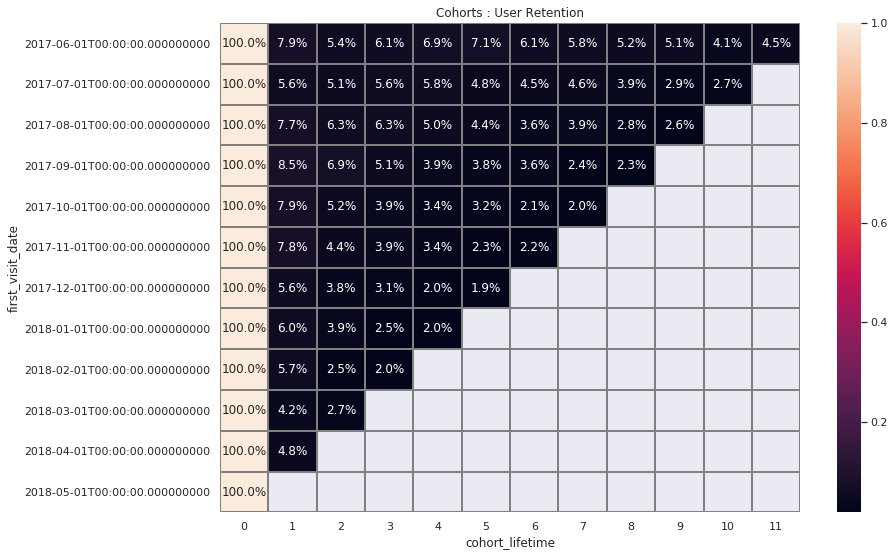

In [42]:
# построим сводную таблицу и тепловую карту для удобства интерпретации результатов retention_rate:

retention_pivot = cohorts.pivot(index='first_visit_date', columns='cohort_lifetime', values='retention')
sns.set(style='dark')
plt.figure(figsize=(13, 9))
plt.title('Cohorts : User Retention')
sns.heatmap(retention_pivot,annot=True, fmt='.1%', linewidths=1, linecolor='grey')


Показатели  Retention Rate очень низкие. Из 100% пользователей на следующий месяц, после первого посещения, на сайт возвращаются меньше 10%. В течение жизни когорты показатели retention rate варьируются из месяца в месяц, но также не превышают 10%. За май месяц у большинства когорт отсутствуют активные пользователи, что говорит о низкой вовлечённости пользователей, которая резко падает с первого месяца, и достигает минимума к апрелю 2018 практически во всех когортах. Самые высокие показатели к концу периода у первой когорты - 4.5% и у апрельской когорты- 4.8% . В других когортах этот показатель не превышает 3%.

Отвечая на поставленный вопрос, пользователи возвращаются очень редко, и с каждым последующим месяцем всё реже. 

### Продажи

- Когда люди начинают покупать?

Для ответа на данный вопрос, нам понадобятся данные из таблиц orders и visits. Необходимо расчитать сколько времени проходит с дня первого визита, до дня первой покупки. Будем исходить из предположения, что некоторые пользователи совершили первую покупку в первый день посещения сайта, поэтому для дальнейших расчётов нам важно оставить время сессий.

In [43]:
#  создадим таблицу, куда сохраним дату первой покупки для каждого пользователя:

first_orders = orders.groupby('uid')['buy_ts'].min().reset_index()
first_orders = first_orders.rename(columns={'buy_ts': 'first_order_time'})
first_orders.head()

,uid,first_order_time
0,313578113262317,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00
3,2464366381792757,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00


In [44]:
#  соединим таблицу orders и first_orders

orders = orders.merge(first_orders, on='uid')


In [45]:
orders

,buy_ts,revenue,uid,first_order_time
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00
...,...,...,...,...
50359,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 23:50:00
50360,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:50:00
50361,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:54:00
50362,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31 23:56:00


In [46]:
# из таблицы visits нам необходимо взять дату первого визита с учётом времени.
# выведем необходимые данные в новую таблицу first_visit_time

first_visit_time = visits.groupby('uid')['start_ts'].min().reset_index()
first_visit_time

,uid,start_ts
0,11863502262781,2018-03-01 17:27:00
1,49537067089222,2018-02-06 15:55:00
2,297729379853735,2017-06-07 18:47:00
3,313578113262317,2017-09-18 22:49:00
4,325320750514679,2017-09-30 14:29:00
...,...,...
228164,18446403737806311543,2017-11-30 03:36:00
228165,18446424184725333426,2017-12-06 20:32:00
228166,18446556406699109058,2018-01-01 16:29:00
228167,18446621818809592527,2017-12-27 13:27:00


In [47]:
# переименум названия столбца start_ts в first_visit_time:

first_visit_time = first_visit_time.rename(columns={'start_ts': 'first_visit_time'})

В получившейся таблице first_visit_time 228169 строк, в то время как в таблице first_orders 36509 строки. Это значит, что из зашедших пользователей, покупку совершает только каждый 6. 
Присоединим таблицу first_visit_time к таблице first_orders по полю 'uid':

In [48]:
# присоединяем таблицы методом merge, прежде выбрав уникальных пользователей:

orders_unique = orders.groupby('uid').agg({'first_order_time':'min'})
orders_unique = orders_unique.merge(first_visit_time, on='uid', how='inner')
orders_unique

,uid,first_order_time,first_visit_time
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00
3,2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00
...,...,...,...
36504,18445147675727495770,2017-11-24 09:03:00,2017-08-20 13:30:00
36505,18445407535914413204,2017-09-22 23:55:00,2017-09-22 23:48:00
36506,18445601152732270159,2018-03-26 22:54:00,2017-08-07 11:51:00
36507,18446156210226471712,2018-02-18 19:34:00,2017-11-07 10:01:00


In [49]:
# теперь отнимем время первой покупки от времени первого визита, и получим отрезок времени спустя который пользователи 
# начинают покупать, а зетем переведём всё в секунды

orders_unique['time_before_first_order'] = orders_unique['first_order_time'] - orders_unique['first_visit_time']
orders_unique['time_before_first_order'] = orders_unique['time_before_first_order'] / np.timedelta64(1, 's')

In [50]:
# проверим данные на коректность, нет ли нулевых значений:

orders_unique[orders_unique['time_before_first_order']==0.0]

,uid,first_order_time,first_visit_time,time_before_first_order
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0.0
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,0.0
9,4992223027560440,2018-04-04 13:54:00,2018-04-04 13:54:00,0.0
36,21801295586117262,2018-01-26 19:14:00,2018-01-26 19:14:00,0.0
77,40600246103358732,2017-07-21 19:08:00,2017-07-21 19:08:00,0.0
...,...,...,...,...
36432,18401744132870849367,2018-04-25 07:24:00,2018-04-25 07:24:00,0.0
36449,18411692028456746897,2018-01-31 19:30:00,2018-01-31 19:30:00,0.0
36463,18417037091353143232,2017-11-23 15:29:00,2017-11-23 15:29:00,0.0
36474,18422020045287977498,2017-12-30 21:32:00,2017-12-30 21:32:00,0.0


2451 строка имеет нулевое значение в столбце 'time_before_first_order'. В реальности такой сюжет не возможен, ведь прежде чем что-то купить, пользователю потребуется время на выбор, заполнение каких-либо данных и оплату. Нулевые показатели принадлежат 2451 пользователю и разбросаны по датам, скорее всего ошибка произошла в процессе выкачивания данных, поэтому использовать эти строки мы не будем. 

In [51]:
# Удалим из таблицы строки, где в столбец time_before_first_order равен 0:

orders_unique['time_before_first_order'].replace(0.0, np.NaN, inplace=True)

In [52]:
orders_unique = orders_unique.dropna(subset=['time_before_first_order']).reset_index(drop=True)

In [53]:
# тепрь найдём средний показатель времени до первой покупки в днях:

orders_unique['time_before_first_order'].mean()/86400

18.13460873118406

С момента первого визита на сайт до совершения первой покупки у пользователей в среднем уходит около 18 дней. 

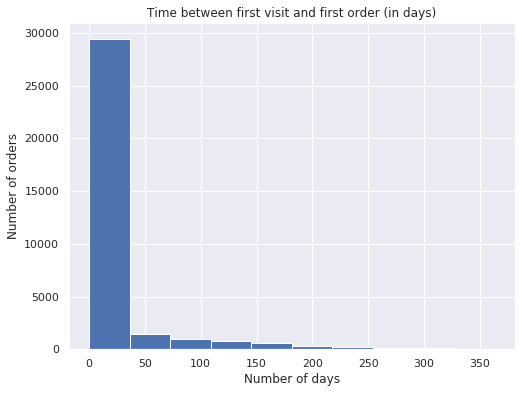

In [54]:
# создадим визуализацию:

plt.figure(figsize=(8,6))
plt.title('Time between first visit and first order (in days)')
plt.xlabel('Number of days')
plt.ylabel('Number of orders')
(orders_unique['time_before_first_order']/86400).hist(bins=10,grid=True)

Как видим по графику, большинство пользователей совершают первый заказ в течение первого месяца.

- Сколько раз покупают за период?

Ответим на вопрос, посчитав показатели за различные временные приоды, за день, за неделю и за месяц.

In [55]:
# для начала извлечём необходимые временные показатели из столбца buy_ts таблицы orders:

orders['order_date'] = orders['buy_ts'].dt.date
orders['order_week'] = orders['buy_ts'].dt.week
orders['order_month'] = orders['buy_ts'].dt.month
orders['order_year'] = orders['buy_ts'].dt.year

In [56]:
# создадим таблицу куда сохраним количество покупок на каждый из дней, и выведем средний показатель:

daily_orders_count = orders.groupby('order_date').agg({'revenue':['count','sum']})
daily_orders_count.columns = daily_orders_count.columns.droplevel(0)
daily_orders_count = daily_orders_count.rename(columns={'count': 'n_orders'})
int(daily_orders_count['n_orders'].mean())

138

 В среднем в день пользователи совершают 138 покупок на сайте. 

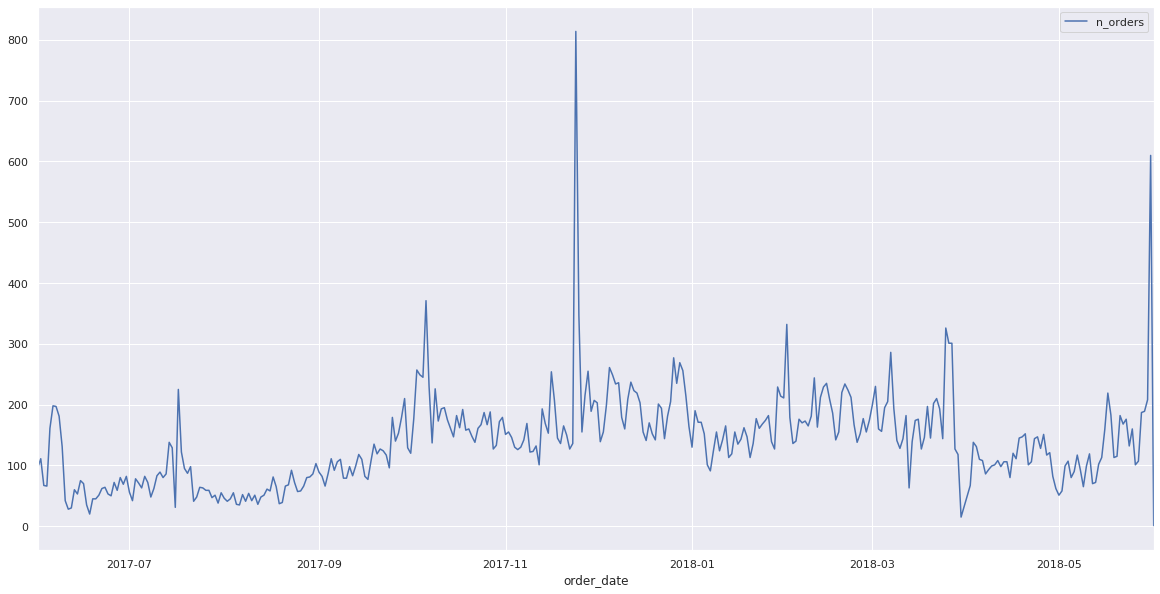

In [57]:
# построим визуализацию:

daily_orders_count.plot(y='n_orders', figsize=(20,10), grid=True)

Количество покупок, совершённых пользователями в течение дня, в основном находится диапазоне от 0 до 300. В декабре 2017 виден резкий скачок вверх, который также стремительно возвращается в привычный диапазон. Скорее всего этот всплеск связан с новогодним праздником. Количество покупок за этот период составило более 700 в день.

In [58]:
# посчитаем количество покупок за неделю для каждой недели в данных.
# а затем выведем среднее:

weekly_orders_count = orders.groupby('order_week').agg({'revenue':['count','sum']})
weekly_orders_count = weekly_orders_count.rename(columns={'count': 'n_orders'})
weekly_orders_count.columns = weekly_orders_count.columns.droplevel(0)
int(weekly_orders_count['n_orders'].mean())

968

В среднем в неделю пользователи совершают 968 покупки с сайта Яндекс.Афиши

In [59]:
# посчитаем количество покупок для каждого месяца и выведем среднее

monthly_orders_count = orders.groupby('order_month').agg({'revenue':['count','sum']})
monthly_orders_count.columns = monthly_orders_count.columns.droplevel(0)
monthly_orders_count = monthly_orders_count.rename(columns={'count':'n_orders'})
int(monthly_orders_count['n_orders'].mean())

4197

В среднем за месяц пользователи совершают 4197 покупку на сайте.

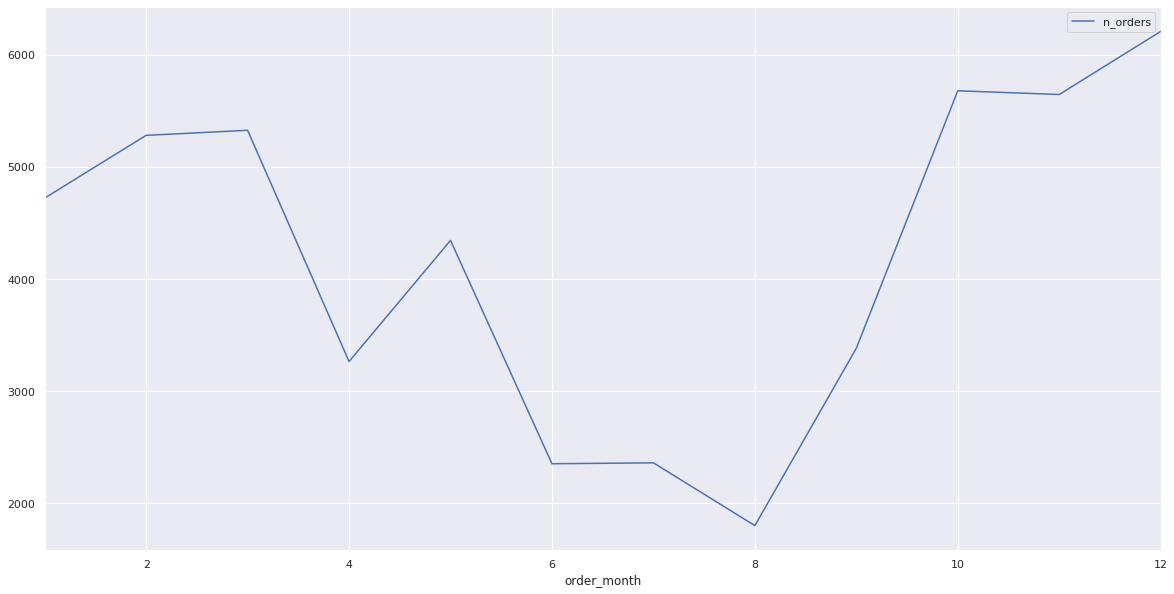

In [60]:
#  построим график и посмотрим на распределение по месяцам:

monthly_orders_count.plot(y ='n_orders', figsize=(20,10), grid=True)

Несмотря на то, что в декабре 2017 был зафиксирован максимум по покупкам за день, в масштабе месяцев дела обстоят совсем по другому.
С июня 2017 идёт постепенное понижение количества покупок, совершенных за месяц. В декабре 2017 этот показатель близок к минимальному, который зафиксирован в январе 2018 года. Такая тенденция наблюдается довольно часто: когда после новогодних праздников уровни продаж существенно падают. Как видим, продажи после января начинают довольно быстро расти и в мае достигают максимума. В мае 2018 количество продаж составило около 6000.

- Какой средний чек?

Рассмотрим показатели по среднему чеку также за разный период - за день, неделю и месяц. Для того, чтобы посчитать средний чек, разделим суммарную прибыль за период на количество продаж. У нас имеются 3 таблицы: daily_orders_count, weekly_orders_count и monthly_orders_count. В них, помимо количества покупок сохранены данные о сумме покупок Будем использовать их для ответа на поставленный вопрос.

In [61]:
#  найдём средний чек за день:

daily_orders_count['daily_revenue_mean'] = daily_orders_count['sum'] / daily_orders_count['n_orders']
daily_orders_count['daily_revenue_mean'].mean()

4.940892816095983

Средний чек за день составляет 4.9 условных единиц

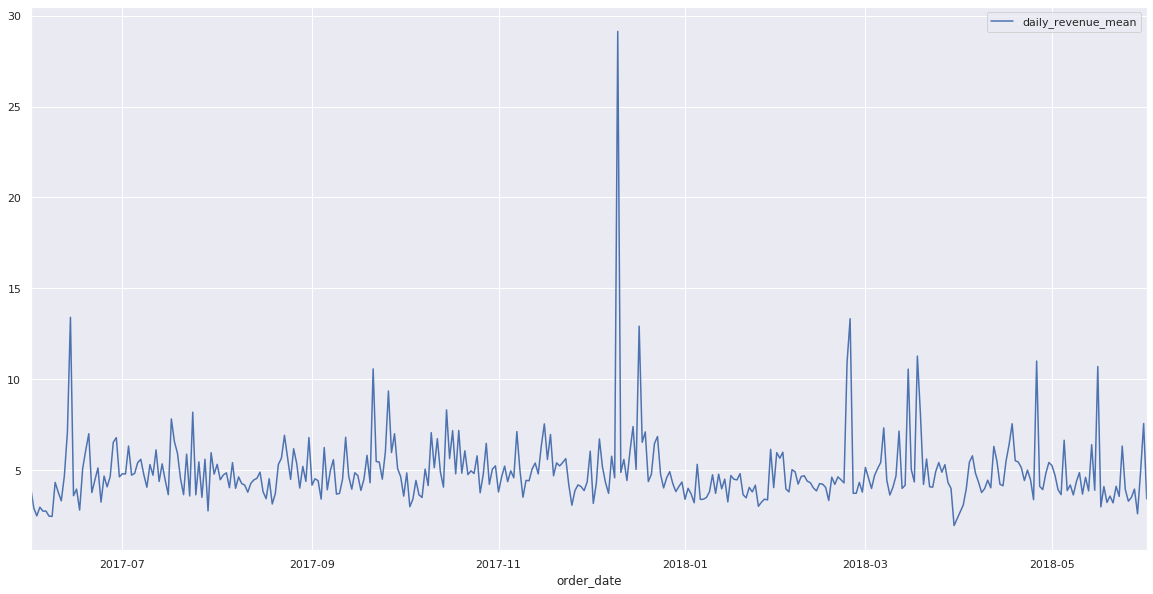

In [62]:
# построим график и посмотрим на распределение значений по дням:

daily_orders_count.plot(y='daily_revenue_mean', figsize=(20,10), grid=True)

Обычно средний чек за день варьируется от 2.2 до 15 условных единиц. В предновогодние дни показатель достиг максимума - 30 условных есдиниц. Это значит, что в этот период выросло не только количество совершаемых покупок, но и средний чек.

In [63]:
# посчитаем средний чек для каждой из недель в таблице и выведем средний чек на неделю:

weekly_orders_count['weekly_revenue_mean'] = weekly_orders_count['sum'] / weekly_orders_count['n_orders'] 
weekly_orders_count['weekly_revenue_mean'].mean()

4.980246901541718

Средний чек за неделю равен среднему чеку за день и равен 4.9 условным единицам.

In [64]:
# найдём величину среднего чека за месяц:

monthly_orders_count['monthly_revenue_mean'] = monthly_orders_count['sum'] / monthly_orders_count['n_orders']
monthly_orders_count['monthly_revenue_mean'].mean()

4.962205652456517

Средний чек в месяц также равен 4.9 условным единицам. Для наглядности изменения величины среднего чека за месяц, построим график временных рядов.

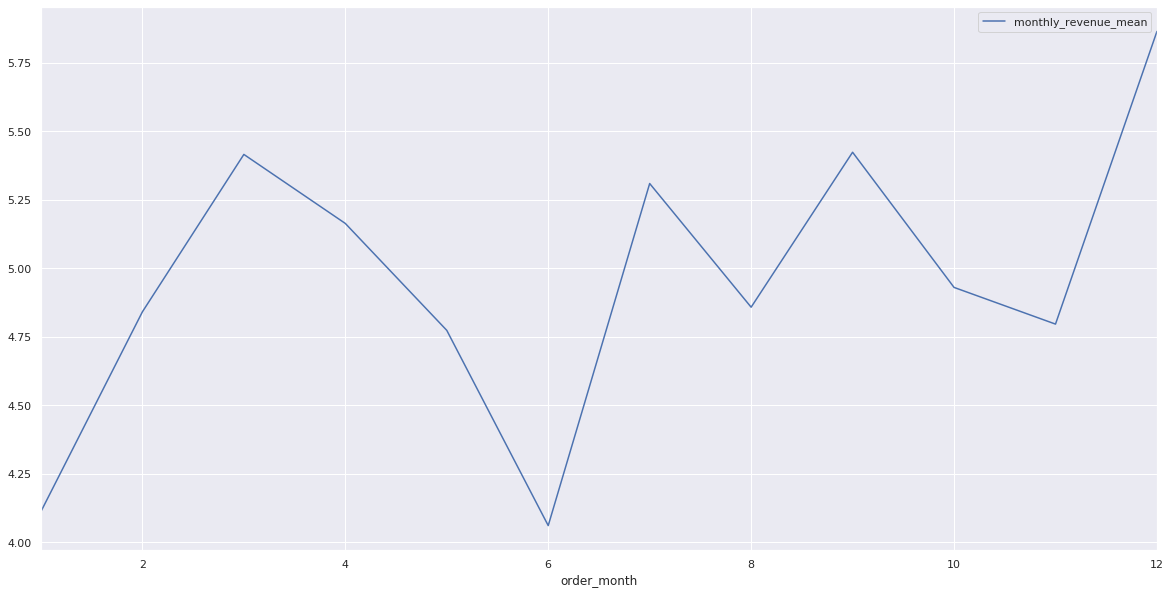

In [65]:
# создадим визуализацию

monthly_orders_count.plot(y='monthly_revenue_mean',figsize=(20,10), grid=True)

Как видим, средний чек за месяц варьируется в диапазоне от 4.15 до 6. Наименьшие показатели приходятся на июнь и ноябрь 2017. Максимальный показатель среднего чека приходится на май 2018, когда он достигает уровня 6 условных единиц. Можно сделать заключение, что показатели по количеству покупок и среднего чека в Яндекс Афише выросли за год и достигли своего максимума.

- Сколько денег приносят? (LTV)

LTV - это итоговая сумма денег, которую клиент приносит в среднем со всех покупок. При расчёте обычно обращаются к валовой прибыли с клиента за период, в данном случае будем обращаться к выручке из таблицы orders.

Метрику LTV удобно считать по когортам, поэтому разобъём пользователей по когортам исходя из даты первой покупки. Будем использовать ранее созданную таблицу first_orders.

In [66]:
# Поменяем вывод даты в столбце first_order_time, сократив до месяца и переименуем столбец в 'first_order_month':

first_orders['first_order_time'] = first_orders['first_order_time'].astype('datetime64[M]')
first_orders = first_orders.rename(columns={'first_order_time': 'first_order_month'})
first_orders.drop([168],inplace=True)

In [67]:
# теперь посчитаем количество новых покупателей за каждый месяц:

cohort_sizes = first_orders.groupby('first_order_month').agg({'uid':'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month','n_buyers']
cohort_sizes

,first_order_month,n_buyers
0,2017-06-01,2022
1,2017-07-01,1922
2,2017-08-01,1369
3,2017-09-01,2579
4,2017-10-01,4340
5,2017-11-01,4078
6,2017-12-01,4380
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3534


In [68]:
# как видим одна запись пришлась на июнь 2016, когорту из неё не образовать, удалим эту запись в таблице first_orders выше
# и в таблице orders:

orders.drop(46456,inplace=True)

In [69]:
# теперь добавим месяц первой покупки в таблицу с заказами- orders:

orders_new = pd.merge(orders, first_orders, on='uid')
orders_new.head()

,buy_ts,revenue,uid,first_order_time,order_date,order_week,order_month,order_year,first_order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,22,6,2017,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,22,6,2017,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,22,6,2017,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,22,6,2017,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,22,6,2017,2017-06-01


In [70]:
# уберём ненужные столбцы из таблицы orders_new, сократим дату заказа до месяца и преименуем столбец в 'order_month'

orders_new['order_date'] = orders_new['order_date'].astype('datetime64[M]')

In [71]:
orders_new.drop(['order_week', 'order_month', 'order_year','first_order_time'], axis = 1, inplace = True) 

In [72]:
orders_new = orders_new.rename(columns={'order_date': 'order_month'})
orders_new.head()

,buy_ts,revenue,uid,order_month,first_order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01


In [73]:
# Сгруппируем таблицу покупок по месяцу первого заказа и месяцу каждого заказа и сложим выручку:

cohorts_orders = orders_new.groupby(['first_order_month', 'order_month']).agg({'revenue':'sum'}).reset_index()
cohorts_orders.head()

,first_order_month,order_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58


In [74]:
# добавим в таблицу cohorts_orders информацию о количестве людей совершивших покупку на сайте в первый раз для каждого месяца:

report = pd.merge(cohort_sizes, cohorts_orders, on='first_order_month')
report.head()

,first_order_month,n_buyers,order_month,revenue
0,2017-06-01,2022,2017-06-01,9557.49
1,2017-06-01,2022,2017-07-01,981.82
2,2017-06-01,2022,2017-08-01,885.34
3,2017-06-01,2022,2017-09-01,1931.30
4,2017-06-01,2022,2017-10-01,2068.58


In [75]:
# добавим в таблицу report колонку с информацией о возрасте когорты:

report['age'] = (report['order_month'] - report['first_order_month'])/ np.timedelta64(1,'M')
report['age'] = report['age'].round().astype('int')

In [76]:
# Тепрь можем посчитать LTV, для этого разделим прибыль когорт за каждый месяц на общее число пользователей в когорте:

report['ltv'] = report['revenue']/report['n_buyers']

In [77]:
# для наглядности визуализируем когорты в виде сводной таблицы:

output = report.pivot_table(index='first_order_month',columns='age', values='ltv' , aggfunc='mean').round(2)
output.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.73,0.49,0.44,0.96,1.02,0.74,0.95,0.58,0.55,0.61,0.57,0.26
2017-07-01,6.01,0.34,0.62,0.36,0.18,0.16,0.12,0.14,0.16,0.15,0.16,
2017-08-01,5.28,0.47,0.46,0.39,0.49,0.28,0.21,0.41,0.29,0.19,,
2017-09-01,5.65,1.12,0.52,3.98,0.4,0.65,0.7,0.24,0.18,,,
2017-10-01,5.00,0.54,0.19,0.16,0.15,0.12,0.08,0.12,,,,
2017-11-01,5.16,0.4,0.2,0.33,0.15,0.05,0.12,,,,,
2017-12-01,4.74,0.26,0.93,1.07,0.31,0.34,,,,,,
2018-01-01,4.14,0.29,0.3,0.14,0.06,,,,,,,
2018-02-01,4.16,0.28,0.08,0.07,,,,,,,,


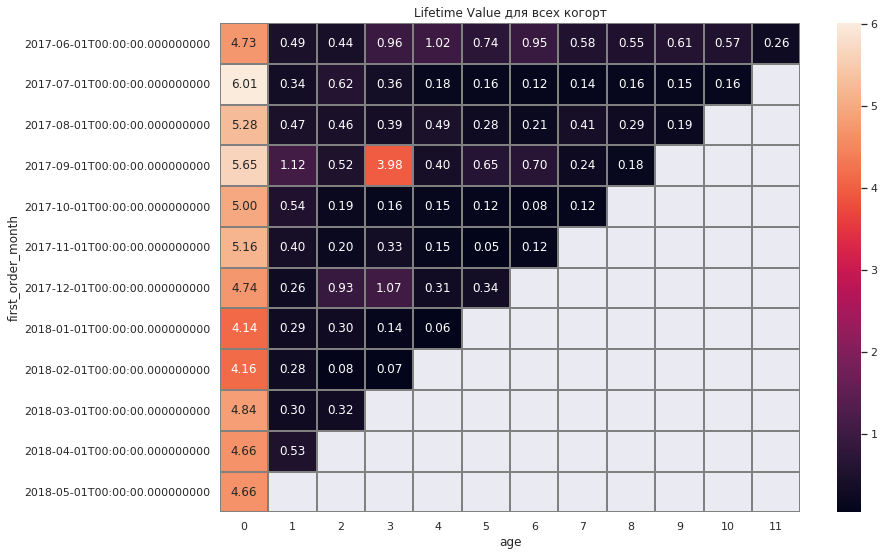

In [78]:
# построим heatmap:
plt.figure(figsize=(13,9))
plt.title('Lifetime Value для всех когорт')
sns.heatmap(output, annot=True, fmt='.2f', linewidth=1, linecolor='grey')

Средняя выручка на каждого покупателя в первый месяц жизни когорты имеет высокие показатели. Это актуально для всех когорт. Но уже со второго месяца показатель падает в несколько раз и почти во всех случаях остаётся таким низким на протяжении всего жизненного цикла когорты. В третьем месяце наиболее высокие показатели у сентябрьской когорты, но к маю 2018 этот показатель становится также низким -0.18

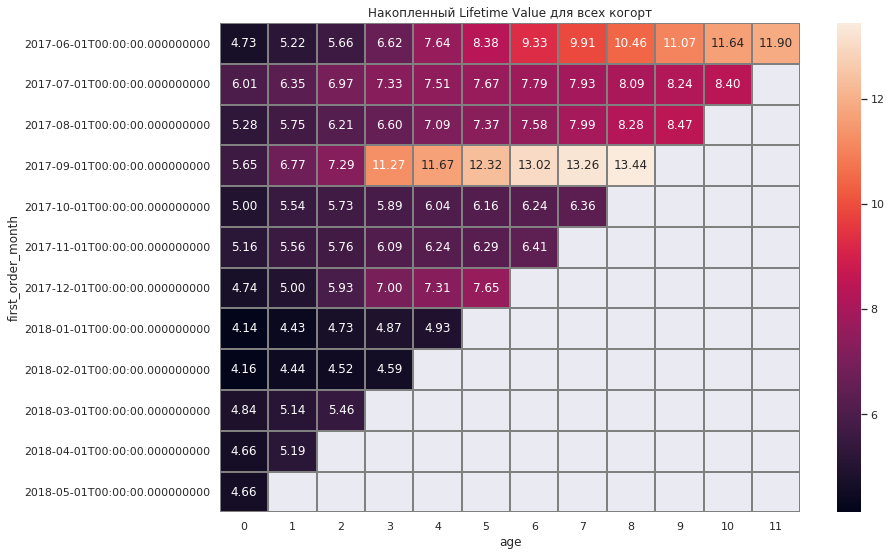

In [79]:
# посмотрим как обстоят дела с накопленным показателем LTV - построим график накопленной выручки для всех когорт:

output_cum = output.cumsum(axis=1)
plt.figure(figsize=(13,9))
plt.title('Накопленный Lifetime Value для всех когорт')
sns.heatmap(output_cum, annot=True, fmt='.2f', linewidth=1, linecolor='grey')

In [80]:
# посчитаем итоговый Lifetime Value для первой когорты:

output.loc['2017-06-01'].sum()

11.9

В среднем каждый покупатель из первой когорты принёс по 11.9 условных единиц выручки за год. Получается по 0.99 за месяц.

In [81]:
# посчитаем LTV для второй когорты:

output.loc['2017-07-01'].sum()

8.4

В среднем каждый покупатель из второй когорты принёс по 8.4 условных единиц выручки за 11 месяцев. Получается по 0.76 за месяц.

In [82]:
# LTV для третьй когорты:

output.loc['2017-08-01'].sum()

8.469999999999999

В среднем каждый покупатель из третей когорты принёс по 8.46 условных единиц выручки за 10 месяцев. Получается по 0.84 за месяц.

In [83]:
# LTV для четвёртой когорты:

output.loc['2017-09-01'].sum()

13.44

В среднем каждый покупатель из четвёртой когорты принёс по 13.4 условных единиц выручки за 9 месяцев. Получается по 1.4 за месяц.

In [84]:
# LTV для пятой когорты:

output.loc['2017-10-01'].sum()

6.359999999999999

В среднем каждый покупатель из пятой когорты принёс по 6.35 условных единиц выручки за 8 месяцев. Получается по 0.79 за месяц.

In [85]:
# LTV для шестой когорты:

output.loc['2017-11-01'].sum()

6.410000000000001

В среднем каждый покупатель из шестой когорты принёс по 6.41 условных единиц выручки за 7 месяцев. Получается по 0.91 за месяц.

In [86]:
# LTV для седьмой когорты:

output.loc['2017-12-01'].sum()

7.65

В среднем каждый покупатель из седьмой когорты принёс по 7.65 условных единиц выручки за 6 месяцев. Получается по 1.27 за месяц.

In [87]:
# LTV для восьмой когорты:

output.loc['2018-01-01'].sum()

4.93

В среднем каждый покупатель из восьмой когорты принёс по 4.93 условных единиц выручки за 5 месяцев. Получается по 0.98 за месяц.

In [88]:
# LTV для девятой когорты:

output.loc['2018-02-01'].sum()

4.590000000000001

В среднем каждый покупатель из девятой когорты принёс по 4.5 условных единиц выручки за 4 месяцев. Получается по 1.1 за месяц.

In [89]:
# LTV для десятой когорты:

output.loc['2018-03-01'].sum()

5.46

В среднем каждый покупатель из девятой когорты принёс по 5.46 условных единиц выручки за 3 месяцев. Получается по 1.82 за месяц.

Наиболее высокие показатели LTV у первых четырёх когорт. Наименьшие у когорт под номером 8, 9, 10.

### Маркетинг

- Сколько денег потратили? Всего / на каждый источник / по времени

In [90]:
# для ответа на поставленнный вопрос нам понадобятся данные из таблицы costs

costs.head()

,source_id,dt,spent
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [91]:
# Посчитаем общие затраты за весь период времени:

costs['spent'].sum()

329131.62

За год на рекламу, включая все рекламные источники было потрачено 329132 условные единицы. 

In [92]:
# посмотрим сколько было потрачено на каждый рекламный источник за весь период:

costs_per_source = costs.groupby('source_id')['spent'].sum().reset_index().sort_values(by='spent', ascending=False)
costs_per_source 

,source_id,spent
2,3,141321.63
3,4,61073.60
4,5,51757.10
1,2,42806.04
0,1,20833.27
6,9,5822.49
5,8,5517.49


Больше всего было затрачено на рекламу с использованием истоника с идентификационным номером 3. Меньше всего на источники под номером 8 и 9. 

In [93]:
# теперь проверим затраты на рекламу на каждый из месяцев в данном периоде.
# для этого создадим новый столбец - month, куда выделим месяц из даты, 
# а после сгруппируем данные по нему и посчитаем сумарные затраты:

costs['month'] = costs['dt'].astype('datetime64[M]')
costs.groupby('month')['spent'].sum().round().reset_index().sort_values(by='spent', ascending=False)

,month,spent
6,2017-12-01,38315.0
5,2017-11-01,37908.0
4,2017-10-01,36323.0
7,2018-01-01,33519.0
8,2018-02-01,32723.0
9,2018-03-01,30415.0
3,2017-09-01,24369.0
10,2018-04-01,22289.0
11,2018-05-01,22224.0
1,2017-07-01,18241.0


 Больше всего затрат на рекламу было совершено декабре, ноябре и октябре 2017 года. Меньше всего - в августе, июне и июле.

- Сколько стоило привлечение одного покупателя из каждого источника?

Для ответа на данный вопрос необходимо сперва определить источник из которого был привлечён пользователь. Выделим источник для каждого пользователя и сохраним его в таблице  visits. Также, в расчёте важно учесть только тех пользователей, которые совершали покупки так как нас интересует стоимость привлечения одного покупателя для каждого источника.

In [94]:
# для нахождения источника создадим функцию, но прежде выделим время первого визита каждого пользователя в отдельный столбец:

first_visit = visits.groupby('uid')['start_ts'].min().reset_index()
first_visit.columns = ['uid', 'first_visit_time']
visits = visits.merge(first_visit, on='uid')

In [95]:
#  создадим функцию и применим к строкам таблицы visits:

def find_initial_source(row):
    if row['start_ts'] == row['first_visit_time']:
        return row['source_id']
    else:
        return 0
    

visits['initial_source'] = visits.apply(find_initial_source, axis=1)

In [96]:
# мы нашли источник из которого был привлечён пользователь для каждого из пользователей, теперь отберём среди них покупателей
# и сохраним данные покупателей и источников в новую таблицу buyers:

visits_users = visits.loc[visits['initial_source']>0,['uid','initial_source']]
orders_buyers = orders.loc[:,['uid','order_date']].reset_index()
buyers = orders_buyers.merge(visits_users, on='uid')
buyers = buyers.groupby('uid')['initial_source'].mean().reset_index()
buyers

,uid,initial_source
0,313578113262317,2
1,1575281904278712,9
2,2429014661409475,3
3,2464366381792757,5
4,2551852515556206,5
...,...,...
36503,18445147675727495770,5
36504,18445407535914413204,3
36505,18445601152732270159,2
36506,18446156210226471712,3


In [97]:
# посчитаем сколько человек пришли с каждого из источников:

users_per_source = buyers.groupby('initial_source')['uid'].count().reset_index()
users_per_source.columns = ['source_id','uid']
users_per_source

,source_id,uid
0,1,2896
1,2,3503
2,3,10467
3,4,10295
4,5,6931
5,7,1
6,8,1088
7,9,1327


In [98]:
# объединим две таблицы - costs_per_source и users_per_source:

costs_per_source = costs_per_source.merge(users_per_source, on='source_id',how='outer')
costs_per_source 

,source_id,spent,uid
0,3,141321.63,10467
1,4,61073.60,10295
2,5,51757.10,6931
3,2,42806.04,3503
4,1,20833.27,2896
5,9,5822.49,1327
6,8,5517.49,1088
7,7,NaN,1


In [99]:
# Данные готовы, рассчитаем сколько стоило привлечение однгого покупателя для каждого рекламного источника:

costs_per_source.columns = ['source_id','spent','n_buyers']
costs_per_source['spent_per_buyer'] = (costs_per_source['spent']/costs_per_source['n_buyers']).round(2)
costs_per_source

,source_id,spent,n_buyers,spent_per_buyer
0,3,141321.63,10467,13.50
1,4,61073.60,10295,5.93
2,5,51757.10,6931,7.47
3,2,42806.04,3503,12.22
4,1,20833.27,2896,7.19
5,9,5822.49,1327,4.39
6,8,5517.49,1088,5.07
7,7,NaN,1,NaN


Как было замечено в начале анализа, рекламные источники с идентификационными номерами 6 и 7 не требуют денежных вложений, кроме того оказалось что они мало эффективны в привлечении активных пользователей, которые конвертируются в покупателей. Рассмотрим источники 1,2,3,4,5,8 и 9. Наиболее затратными на привлечение новых покупателей являются рекламные источники 2 и 3. Привлечение одного покупателя обошлось в 13.34 и 14.25 условных единиц соответственно. Наименее затратные источники: 8 и 9, затраты на которые составили 5.27 и 4.69 условных единиц. У источников под номерами 1,4 и 5 затраты средние от 6.25 до 8.25 условных единиц. Рассмотрим помимо затрат эффективность привлечения пользователей. Источники под номером 3 и 4 привлекли наибольшее количество пользователей, которые позже конвертировались в покупателей, 9918 и 9779 человек соответственно. Учитывая схожую эффективность этих двух источников, можно уменьшить часть затрат на дорогостоящий источник под номером 3 и вложить их в источник под номером 4. Наименее затратные источники 8 и 9 привлекли меньше всего покупателей. Источники 1 и 2 привлекли чуть больше 2526 и 3208 человек. Учитывая, что источник под номером 2 является затратным, но не сильно эффективен в привлечении новых пользователей, затраты на него следует сократить. Источник номер 5 привлёк почти в два раза больше покупателей, чем источник номер 2, но стоило это на 6 условных единиц меньше - из расчёта на одного человека. Так что можно перенаправить часть маркетинговых затрат на источник под номером 5. 

- На сколько окупились расходы? (ROI)

Для ответа на вопрос, нам необходимо вычесть расходы на маркетинг(CAC) от LTV и разделить всё на показатель CAC. Данные по доходам с каждой из когорт с разбивкой по месяцам хранятся в таблице 'report'.

In [100]:
# посчитаем расходы за каждый месяц из периода:

monthly_costs = costs.groupby('month')['spent'].sum().reset_index()
monthly_costs

,month,spent
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88
5,2017-11-01,37907.88
6,2017-12-01,38315.35
7,2018-01-01,33518.52
8,2018-02-01,32723.03
9,2018-03-01,30415.27


In [101]:
# теперь добавим данные о рассходах в таблицу report и посчитаем CAC:

report_new = pd.merge(report, monthly_costs, left_on='first_order_month', right_on='month')
report_new['cac'] = report_new['spent']/report_new['n_buyers']
report_new.head()

,first_order_month,n_buyers,order_month,revenue,age,ltv,month,spent,cac
0,2017-06-01,2022,2017-06-01,9557.49,0,4.726751,2017-06-01,18015.0,8.909496
1,2017-06-01,2022,2017-07-01,981.82,1,0.485569,2017-06-01,18015.0,8.909496
2,2017-06-01,2022,2017-08-01,885.34,2,0.437854,2017-06-01,18015.0,8.909496
3,2017-06-01,2022,2017-09-01,1931.30,3,0.955143,2017-06-01,18015.0,8.909496
4,2017-06-01,2022,2017-10-01,2068.58,4,1.023037,2017-06-01,18015.0,8.909496


In [102]:
# теперь посчитаем накопительный ROMI и для наглядности построим таблицу:

report_new['romi'] = report_new['ltv']/report_new['cac']
table = report_new.pivot_table(index='first_order_month', columns='age',values='romi', aggfunc='mean')
table_cum = table.cumsum(axis=1).round(2)
table_cum.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,0.53,0.59,0.63,0.74,0.86,0.94,1.05,1.11,1.17,1.24,1.31,1.33
2017-07-01,0.63,0.67,0.73,0.77,0.79,0.81,0.82,0.84,0.85,0.87,0.88,
2017-08-01,0.49,0.53,0.57,0.61,0.66,0.68,0.7,0.74,0.77,0.78,,
2017-09-01,0.60,0.72,0.77,1.19,1.23,1.3,1.38,1.4,1.42,,,
2017-10-01,0.60,0.66,0.68,0.7,0.72,0.74,0.75,0.76,,,,
2017-11-01,0.56,0.6,0.62,0.65,0.67,0.68,0.69,,,,,
2017-12-01,0.54,0.57,0.68,0.8,0.84,0.87,,,,,,
2018-01-01,0.42,0.45,0.48,0.49,0.5,,,,,,,
2018-02-01,0.46,0.49,0.5,0.51,,,,,,,,


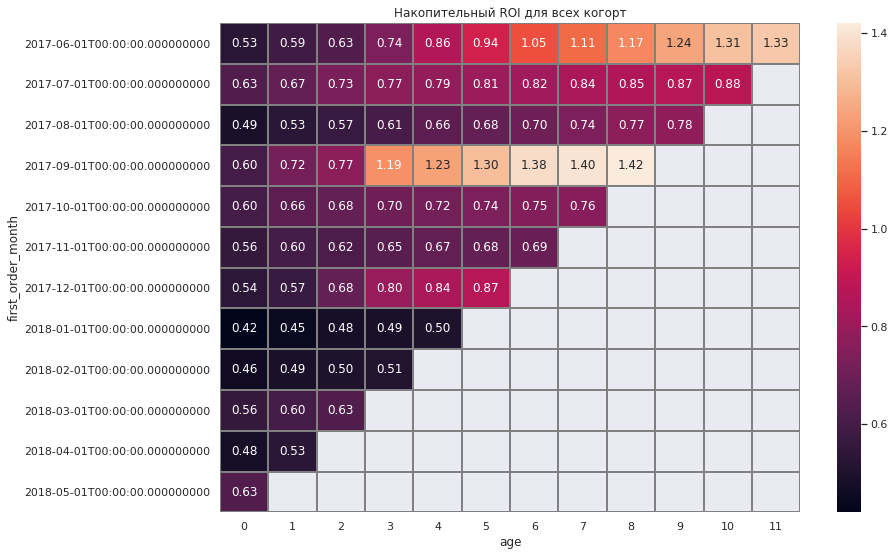

In [103]:
plt.figure(figsize=(13,9))
plt.title('Накопительный ROI для всех когорт')
sns.heatmap(table_cum, annot=True, fmt='.2f', linewidth=1, linecolor='grey')

Показатели ROI указывают на то, что самая быстро окупившаяся когорта - сентябрьская, она окупилась уже на 4 месяц. Первая когорта окупилась на 7 месяц. Остальные когорты так и не окупились. В большинстве когорт половина затрат окупается в первые два месяца, но после этого показатели растут очень медленно. Из 12 когорт затраты окупились только у двух.

In [104]:
# посмотрим на показатели с учётом рекламного источника привлечения пользователей.
# для этого рассчитаем расходы на привлечение каждого покупателя для каждого источника и запишем полученную информацию 
# в таблицу buyers:

visits_users = visits.loc[visits['initial_source']>0,['uid','initial_source','device']]
orders_buyers = orders.loc[:,['uid','order_date','revenue']].reset_index()
buyers_initial = orders_buyers.merge(visits_users, on='uid')
buyers = buyers_initial.groupby('uid')[['initial_source','order_date', 'device']].min().reset_index()
buyers.head()

,uid,initial_source,order_date,device
0,313578113262317,2,2018-01-03,desktop
1,1575281904278712,9,2017-06-03,touch
2,2429014661409475,3,2017-10-11,desktop
3,2464366381792757,5,2018-01-28,desktop
4,2551852515556206,5,2017-11-24,desktop


In [105]:
# в таблице costs_per_source у нас хранится информация о затратах на рекламу из расчёта на одного человека,
# добавим эту информацию в таблицу buyers, объединив таблицы:

buyers = pd.merge(buyers, costs_per_source, left_on='initial_source', right_on='source_id').reset_index()

In [106]:
# посчитаем рассходы за каждый месяц, с учётом источника привлечения
# для начала упорядочим таблицу:

buyers = buyers.drop(columns=['index','spent','n_buyers','initial_source'])
buyers['order_date'] = buyers['order_date'].astype('datetime64[M]')


In [107]:
# найдём lifetime value с учётом источника, откуда пришёл пользователь
# будем использовать данные таблиц buyers и orders_buyers:

ltv_by_source = pd.merge(orders_buyers, buyers, left_on='uid', right_on='uid')
ltv_by_source = ltv_by_source.rename(columns={'order_date_x':'order_date'})
ltv_by_source['order_date'] = ltv_by_source['order_date'].astype('datetime64[M]')
ltv_by_source = ltv_by_source.groupby(['order_date', 'source_id']).agg({'uid':'count','revenue':'sum'}).reset_index()
ltv_by_source['ltv_by_source'] = ltv_by_source['revenue']/ltv_by_source['uid']
ltv_by_source.head()


,order_date,source_id,uid,revenue,ltv_by_source
0,2017-06-01,1,268,1378.70,5.144403
1,2017-06-01,2,280,1043.68,3.727429
2,2017-06-01,3,704,2804.34,3.983438
3,2017-06-01,4,467,1959.84,4.196660
4,2017-06-01,5,447,1898.89,4.248076


In [108]:
# сгруппируем данные, соединим таблицу с таблицей report и посчитаем CAC:

monthly_costs_by_source = buyers.groupby(['order_date', 'source_id']).agg({'spent_per_buyer':'sum','uid':'count'}).reset_index()
report_source = pd.merge(report_new, monthly_costs_by_source, left_on='first_order_month', right_on='order_date')
report_source['cac_by_source'] = report_source['spent_per_buyer']/ report_source['uid']

In [109]:
# выберем нужные нам стодлбцы и выделим их в таблицу report_source_new:

report_source_new = report_source[:][['first_order_month', 'order_month','source_id', 'age', 'cac_by_source']]
report_source_new.head()

,first_order_month,order_month,source_id,age,cac_by_source
0,2017-06-01,2017-06-01,1,0,7.19
1,2017-06-01,2017-06-01,2,0,12.22
2,2017-06-01,2017-06-01,3,0,13.50
3,2017-06-01,2017-06-01,4,0,5.93
4,2017-06-01,2017-06-01,5,0,7.47


In [110]:
# прежде чем расчитывать ROMI, добавим данные LTV с учётом источников в таблицу report_source_new:
# а также обновим значения столбца age:

final_report = pd.merge(ltv_by_source,report_source_new, left_on=['order_date','source_id'],right_on=['first_order_month','source_id'])
final_report = final_report.drop(columns='age')
final_report['age'] = ((final_report['order_month'] - final_report['first_order_month'])/ np.timedelta64(1,'M')).round().astype('int')

In [111]:
# теперь посчитаем накопительный ROMI и построим таблицу для наглядности:

final_report['cac_by_source'].replace(0, np.NaN,inplace=True )
final_report['romi_by_source'] = (final_report['ltv_by_source']/ final_report['cac_by_source']).round(2)
final_table = final_report.pivot_table(index=['first_order_month','source_id'], columns='age',values='romi_by_source', aggfunc='mean')
final_table_cum = final_table.cumsum(axis=1).round(2)
final_table_cum

age                            0     1     2     3     4     5     6     7   \
first_order_month source_id                                                   
2017-06-01        1          0.72  1.44  2.16  2.88  3.60  4.32  5.04  5.76   
                  2          0.31  0.62  0.93  1.24  1.55  1.86  2.17  2.48   
                  3          0.30  0.60  0.90  1.20  1.50  1.80  2.10  2.40   
                  4          0.71  1.42  2.13  2.84  3.55  4.26  4.97  5.68   
                  5          0.57  1.14  1.71  2.28  2.85  3.42  3.99  4.56   
...                           ...   ...   ...   ...   ...   ...   ...   ...   
2018-05-01        3          0.31   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
                  4          0.74   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
                  5          0.53   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
                  8          0.77   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
                  9          0.73   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

age                            8    9     10    11  
first_order_month source_id                         
2017-06-01        1          6.48  7.2  7.92  8.64  
                  2          2.79  3.1  3.41  3.72  
                  3          2.70  3.0  3.30  3.60  
                  4          6.39  7.1  7.81  8.52  
                  5          5.13  5.7  6.27  6.84  
...                           ...  ...   ...   ...  
2018-05-01        3           NaN  NaN   NaN   NaN  
                  4           NaN  NaN   NaN   NaN  
                  5           NaN  NaN   NaN   NaN  
                  8           NaN  NaN   NaN   NaN  
                  9           NaN  NaN   NaN   NaN  

[84 rows x 12 columns]

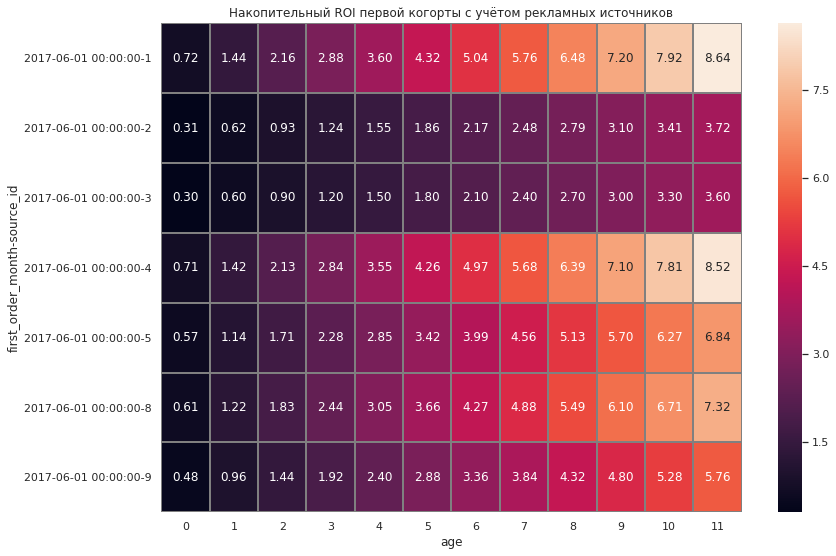

In [112]:
#  Так как строк в таблице много, будем рассматривать каждую когорту по отдельности.
# Выведем часть таблицы с информауией по первой когорте:

plt.figure(figsize=(13,9))
plt.title('Накопительный ROI первой когорты с учётом рекламных источников')
sns.heatmap(final_table_cum[:7], annot=True, fmt='.2f', linewidth=1, linecolor='grey')

Показатели  ROMI для первой когорты с учётом источника привлечения пользователя:

Рекламные источники под номером 1,4, 5 и 8 окупаются уже во втором месяце. За год наиболее выгодными в плане окупаемости стали источники под номером 1, 4, 5, 8. Дольше всего окупался рекламный источник номер 3 - четыре месяца, к концу года его коэффициент ROI самый низкий- 3.60. В целом, рекламные источники окупаются довольно быстро.

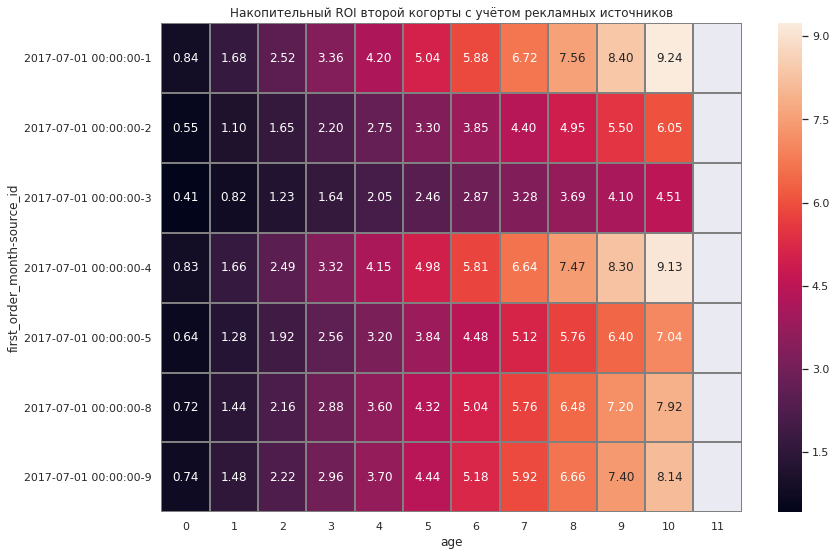

In [113]:
# Посмотрим показатели ROI для второй когорты:

plt.figure(figsize=(13,9))
plt.title('Накопительный ROI второй когорты с учётом рекламных источников')
sns.heatmap(final_table_cum[7:14], annot=True, fmt='.2f', linewidth=1, linecolor='grey')


Для второй когорты наиболее результативными оказались источники под номером 1,2,4,5,8 и 9 - они окупились на второй месяц и к концу года коэфициент их окупаемости находился в диапазоне от 7 до 9. Наименее прибыльный источник - 3. К сентябрю затраты на иююльскую когорту окупились для всех рекламных источников.

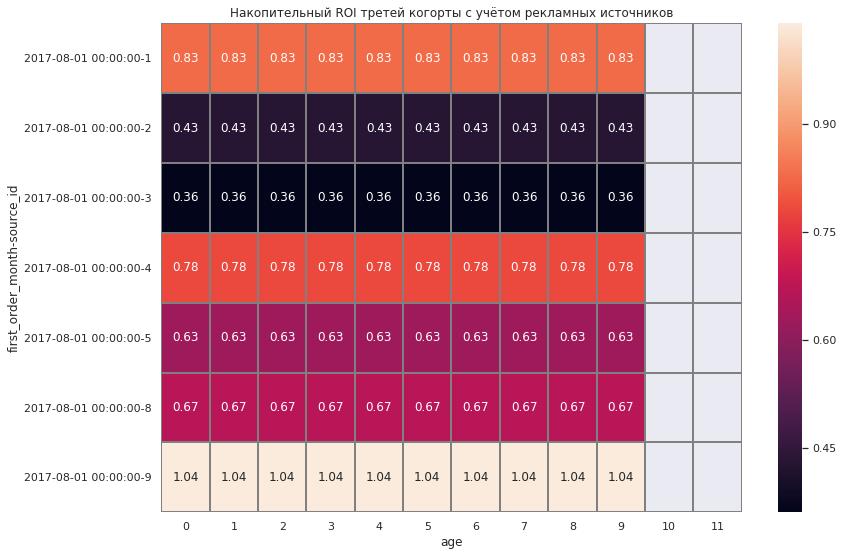

In [114]:
# Показатели ROI для третей когорты:

plt.figure(figsize=(13,9))
plt.title('Накопительный ROI третей когорты с учётом рекламных источников')
sns.heatmap(final_table[14:21], annot=True, fmt='.2f', linewidth=1, linecolor='grey')


В третьей когорте результаты рекламных источников меняются, источник номер 9 окупился в первом месяце, другие не окупились совсем. Третья когорта менее активная чем две предыдущие, здесь показатель ROI не меняется с течением времени.

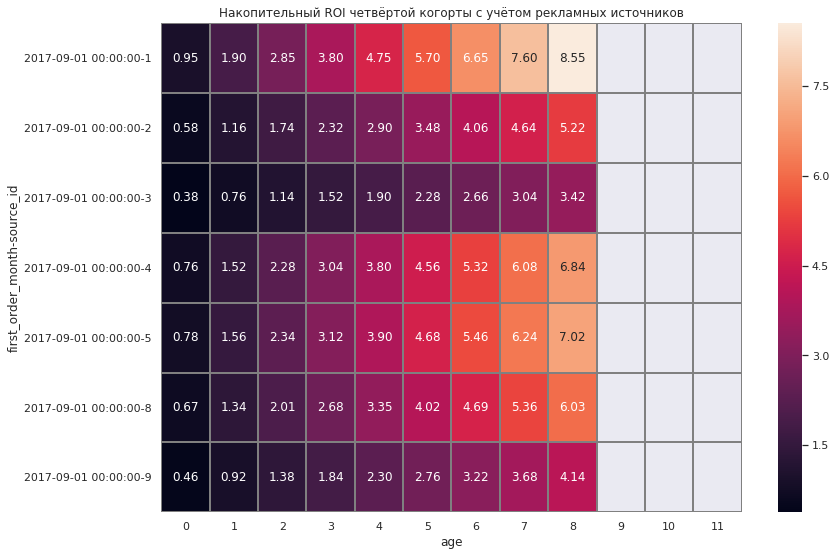

In [115]:
# показатели ROI для четвёртой когорты:

plt.figure(figsize=(13,9))
plt.title('Накопительный ROI четвёртой когорты с учётом рекламных источников')
sns.heatmap(final_table_cum[21:28], annot=True, fmt='.2f', linewidth=1, linecolor='grey')


Сентябрьская когорта имеет высокие показатели ROI в целом, пять из семи источников рекламы окупились уже во втором месяце. Наиболее эффективными можно считать источник номер 1, 4, 5 и 6 - окупились они быстро и у них высокие показатели на конец периода, то есть на май 2018 года. Источники под номером 2 и 8 окупились также быстро, но под конец года их коэфициент ниже. Наименее выгодные источники - 3 и 9.

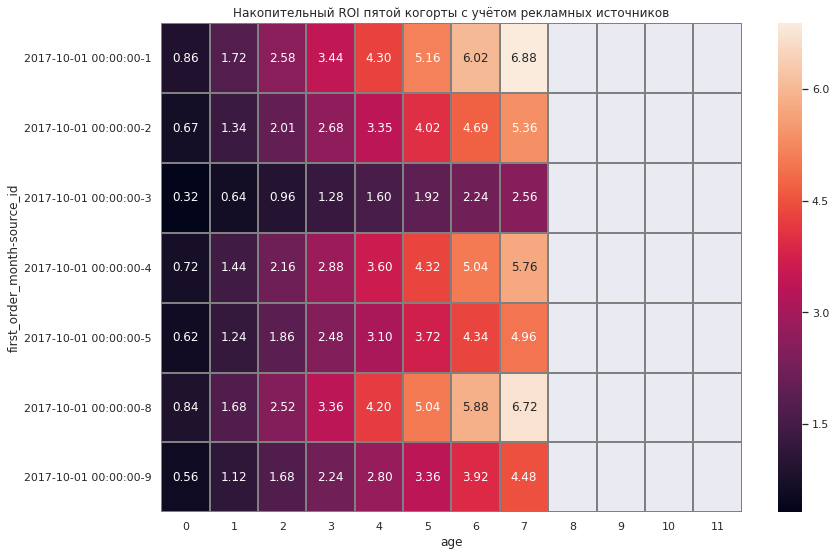

In [116]:
# показатели ROI для пятой когорты:

plt.figure(figsize=(13,9))
plt.title('Накопительный ROI пятой когорты с учётом рекламных источников')
sns.heatmap(final_table_cum[28:35], annot=True, fmt='.2f', linewidth=1, linecolor='grey')


В пятой когорте, затраты на рекламу окупились во втором месяце для шести источников из семи. Довольно высокий показатель. Дольше всего окупался источник номер 3 - только на четвёртый месяц.

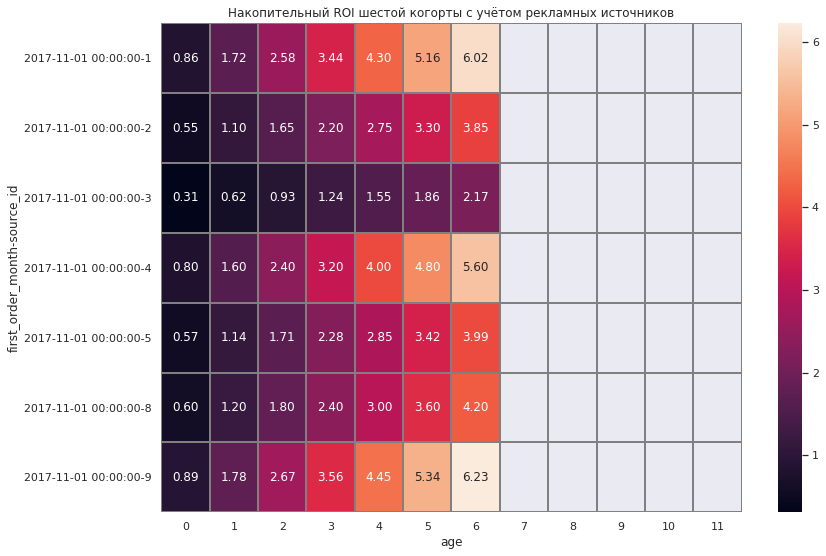

In [117]:
# показатели ROI для шестой когорты:

plt.figure(figsize=(13,9))
plt.title('Накопительный ROI шестой когорты с учётом рекламных источников')
sns.heatmap(final_table_cum[35:42], annot=True, fmt='.2f', linewidth=1, linecolor='grey')


Ноябрьская когорта имеет также высокие показатели метрики ROI. Шесть из семи рекламных источников окупились на второй месяц, исключение составил источник номер 3. 

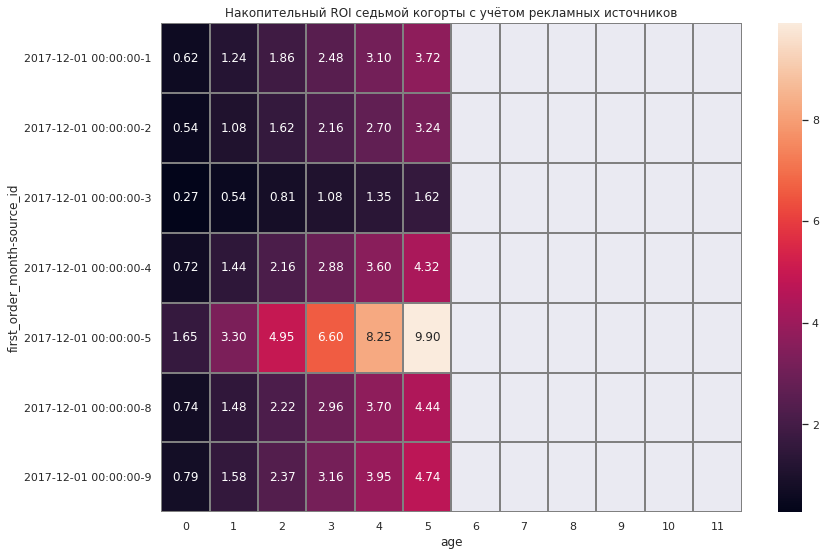

In [118]:
#  показатели ROI для седьмой когорты:

plt.figure(figsize=(13,9))
plt.title('Накопительный ROI седьмой когорты с учётом рекламных источников')
sns.heatmap(final_table_cum[42:49], annot=True, fmt='.2f', linewidth=1, linecolor='grey')


В седьмой когорте наиболее прибыльным стал источник номер 5. Затраты окупились в первом месяце, а итоговый коэфициент в 9 раз превысил сумму затрат. Наименее эффективный - источник под номером 3, который окупился только на четвёртый месяц. 

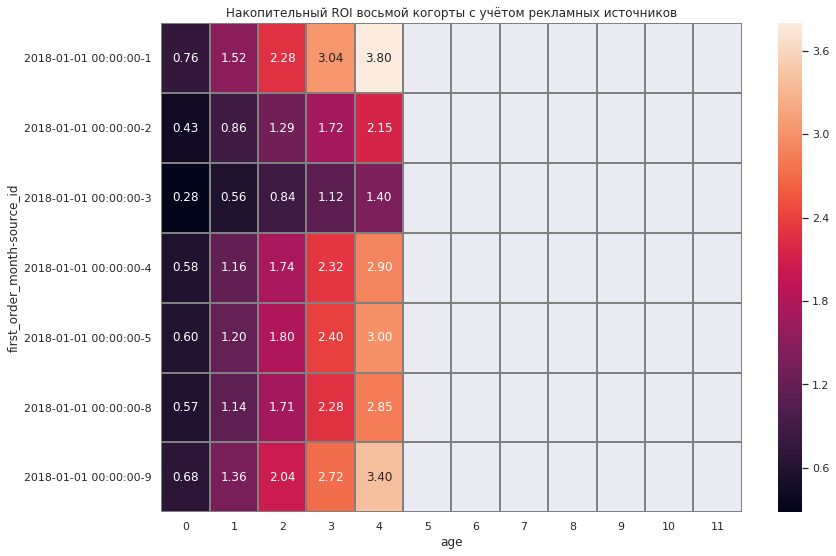

In [119]:
#  показатели ROI для восьмой когорты:

plt.figure(figsize=(13,9))
plt.title('Накопительный ROI восьмой когорты с учётом рекламных источников')
sns.heatmap(final_table_cum[49:56], annot=True, fmt='.2f', linewidth=1, linecolor='grey')


В январьской когорте источники с наивысшим коэфициентом окупаемости - это источники под номером 1 и 9. С наименьшим коэфициентом - источник номер 3, который окупился только на четвёртый месяц.  

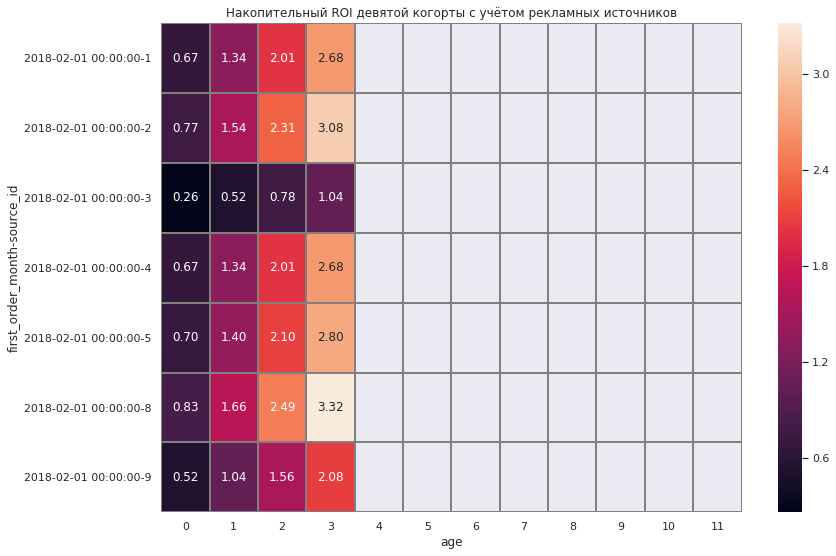

In [120]:
#  показатели ROI для девятой когорты:

plt.figure(figsize=(13,9))
plt.title('Накопительный ROI девятой когорты с учётом рекламных источников')
sns.heatmap(final_table_cum[56:63], annot=True, fmt='.2f', linewidth=1, linecolor='grey')


Затраты на истоник номер 3 покрылись в четвёртом месяце, на все остальные - во втором месяце.

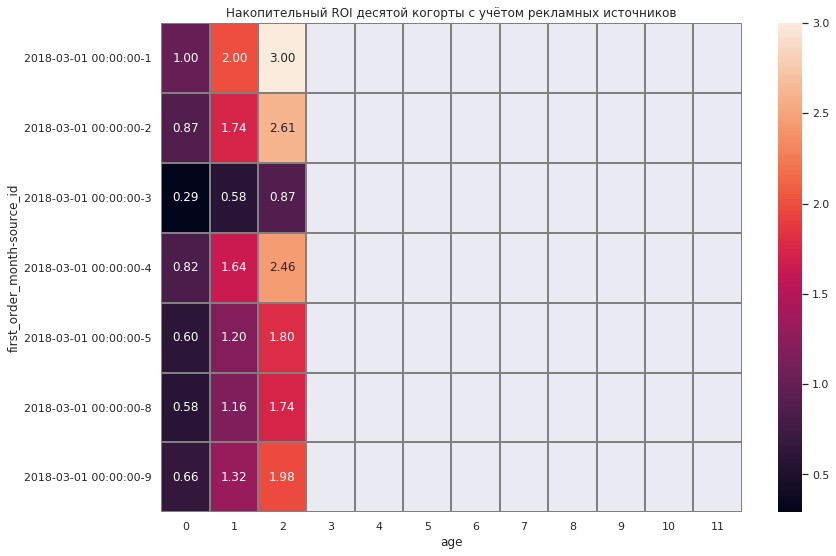

In [121]:
#  показатели ROI для десятой когорты:

plt.figure(figsize=(13,9))
plt.title('Накопительный ROI десятой когорты с учётом рекламных источников')
sns.heatmap(final_table_cum[63:70], annot=True, fmt='.2f', linewidth=1, linecolor='grey')


В мартовской когорте шесть из семи источников окупились на второй месяц. Не окупился совсем источник номер 3. Источники под номером 1, 2 и 4 имеют высокие показатели окупаемости уже в первом месяце. Также коэфициент на май 2018 для этих источников более чем в два раза превышает затраты на них.

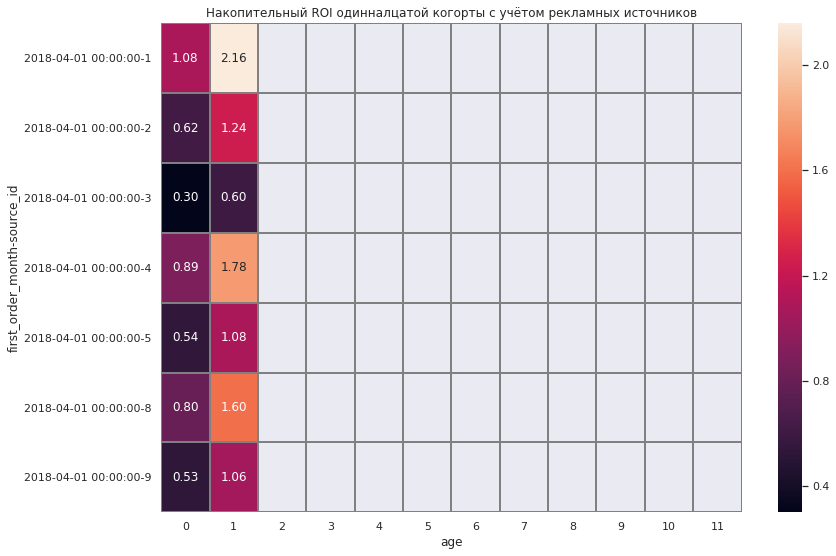

In [122]:
#  показатели ROI для одинналцатой когорты:

plt.figure(figsize=(13,9))
plt.title('Накопительный ROI одинналцатой когорты с учётом рекламных источников')
sns.heatmap(final_table_cum[70:77], annot=True, fmt='.2f', linewidth=1, linecolor='grey')


Все источники, кроме третьего окупились ко второму месяцу.

Общий анализ ROI рекламных источников для всех когорт:

Источники номер 1,2,4,5,8 имеют высокие показатели окупаемости уже с первого месяца. В большинстве случаев - около 70%, а во втором месяце затраты обычно окупаются полностью с плюсом более 40%. Источник с наименьшим коэфициентом окупаемости и наиболее длительным сроком - источник номер 3. Итоговые показатели источника под номером 9 варьируются от низких до средних.

#### Подсчёт значений LTV для пользователей с разными устройствами с разбивкой по когортам:

In [123]:
# для расчётов будем использовать ранее созданные таблицы - buyers_initial и orders_new

buyers_initial = buyers_initial.drop(50362, axis=0)
buyers_initial['order_date'] = buyers_initial['order_date'].astype('datetime64[M]')
buyers_initial_grouped = buyers_initial.groupby(['uid','order_date']).agg({'device':'max','revenue':'sum'}).reset_index()
orders_new_grouped = orders_new.groupby(['uid','order_month']).agg({'first_order_month':'min'}).reset_index()


In [124]:
buyers_initial_grouped

,uid,order_date,device,revenue
0,313578113262317,2018-01-01,desktop,0.55
1,1575281904278712,2017-06-01,touch,3.05
2,2429014661409475,2017-10-01,desktop,73.33
3,2464366381792757,2018-01-01,desktop,2.44
4,2551852515556206,2017-11-01,desktop,10.99
...,...,...,...,...
40992,18445147675727495770,2017-11-01,touch,3.05
40993,18445407535914413204,2017-09-01,desktop,0.88
40994,18445601152732270159,2018-03-01,desktop,4.22
40995,18446156210226471712,2018-02-01,desktop,9.78


In [125]:
# объединим две таблицы:

buyers_initial_grouped = pd.merge(buyers_initial_grouped, orders_new_grouped, on='uid')
buyers_initial_grouped.head()

,uid,order_date,device,revenue,order_month,first_order_month
0,313578113262317,2018-01-01,desktop,0.55,2018-01-01,2018-01-01
1,1575281904278712,2017-06-01,touch,3.05,2017-06-01,2017-06-01
2,2429014661409475,2017-10-01,desktop,73.33,2017-10-01,2017-10-01
3,2464366381792757,2018-01-01,desktop,2.44,2018-01-01,2018-01-01
4,2551852515556206,2017-11-01,desktop,10.99,2017-11-01,2017-11-01


In [126]:
# посчитаем ltv:

ltv_by_device = buyers_initial_grouped.groupby(['first_order_month', 'order_date','device']).agg({'uid':'count','revenue':'sum'}).reset_index()
ltv_by_device = ltv_by_device.rename(columns={'uid':'n_buyers'})
ltv_by_device['ltv_by_device'] = ltv_by_device['revenue'] / ltv_by_device['n_buyers']

In [127]:
# построим таблицу и визуализируем показатели ltv по когортам, с учётом устройств:

ltv_by_device['cohort_age'] = (ltv_by_device['order_date'] - ltv_by_device['first_order_month'])/ np.timedelta64(1,'M')
ltv_by_device['cohort_age'] = ltv_by_device['cohort_age'].round().astype('int')
output_device_ltv = ltv_by_device.pivot_table(index=['first_order_month','device'], columns='cohort_age', values='ltv_by_device', aggfunc='mean')


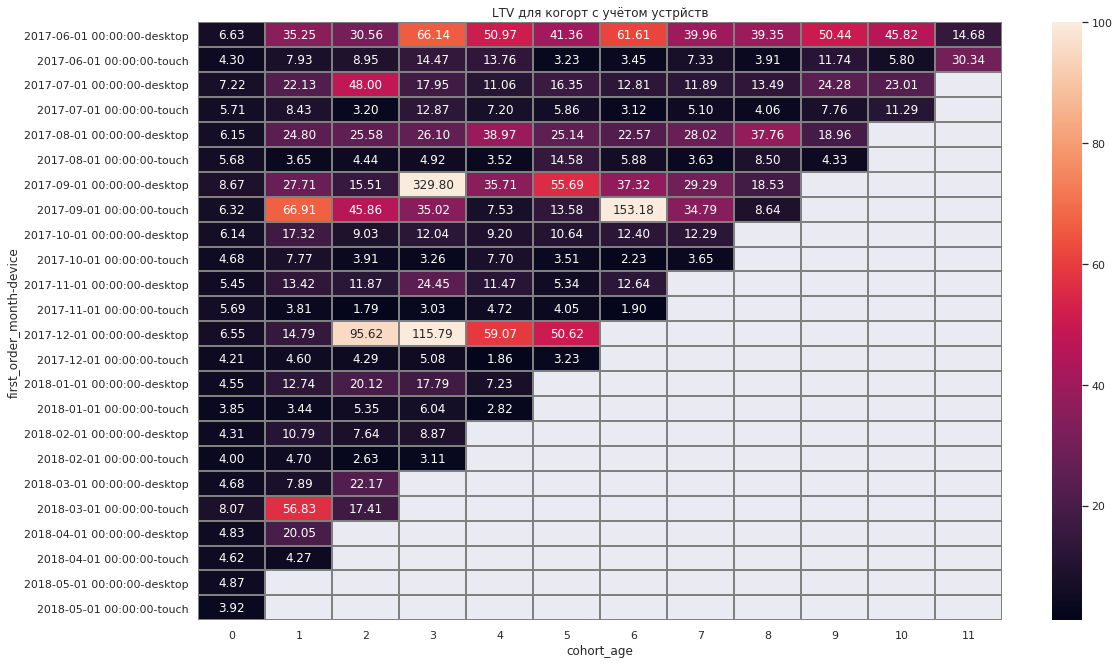

In [128]:
# создадим heatmap:

plt.figure(figsize=(18,11))
plt.title('LTV для когорт с учётом устрйств')
sns.heatmap(output_device_ltv, vmin=1, vmax=100, annot=True, fmt='.2f', linewidth=1, linecolor='grey')

Для большинства когорт показатели LTV у пользователей устройст типа desktop в несколько раз превышают показатели пользователей, использующих устройства типов touch за тот же период времени. В сентябрьской когорте показатели чередуются. 

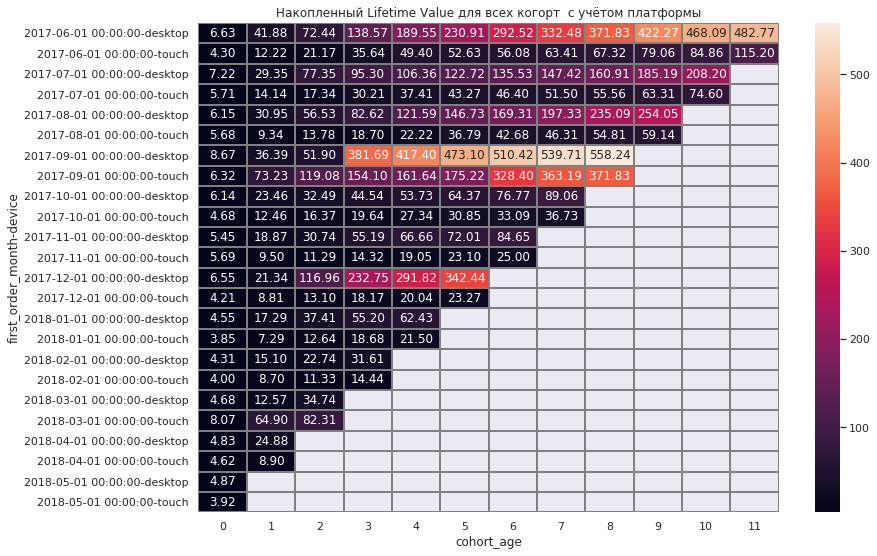

In [129]:
# посмотрим как обстоят дела с накопленным показателем LTV - построим график накопленной выручки для всех когорт:

output_device_ltv_cum = output_device_ltv.cumsum(axis=1)
plt.figure(figsize=(13,9))
plt.title('Накопленный Lifetime Value для всех когорт  c учётом платформы')
sns.heatmap(output_device_ltv_cum, annot=True, fmt='.2f', linewidth=1, linecolor='grey')

В среднем показатель LTV на пользователя с устройством desktop значительно выше LTV пользователя с устройством touch. В среднем каждый пользователь июньской когорты с устройством desktop за год принёс 482.77  условных единиц, то есть 40 условных единиц в месяц. В то время как для пользователя той же когорты но использовавшего устройство touch - средний месячный показатель равен 9.5 условным единицам. То есть почти в 5 раз меньше. В сентябрьской когорте значения LTV для пользователей двух видов устройств выше показателей всех остальных когорт с учётом устройств. Накопительный lifetimevalue выше для пользователей устройства desktop во всех когортах за исключением мартовской. Пользователи заходящие с компьютеров приносят больше прибыли, чем пользователи заходящие с телефонов и планшетов. Это может говорить о том, что версия  desktop более удобна для совершения покупок, чем версия сервиса на устройствах touch. 

### Шаг 3. Общий вывод

Порекомендуйте маркетологам, куда и сколько им стоит вкладывать денег? Какие источники/платформы вы бы порекомендовали? Объясните свой выбор: на какие метрики вы ориентируетесь? Почему? Какие выводы вы сделали, узнав значение метрик?

В данном проекте мы проводили аналитику данных Яндекс Афиши с целью оптимизации маркетинговых затрат. Исходя из результатов анализа, можно дать следующие рекомендации: 

#### Рекомендации:

<b>1. Построить воронку и выяснить, на каких этапах сайт теряет большую часть пользователей.</b> По данным анализа, метрика Average Session Lenght равна одной минуте и это двольно короткий промежуток времени. Но всё зависит от контекста, который нам пока не известен. Возможно структура сайта не совсем удобна для использования. А может, много людей заходят ради интереса, так как впервые узнают о серсисе, и им хватает одной минуты для знакомства с ним. Или большинство заходит с целью - купить билет, и управляется с этим за минуту. Важно выяснить причины такого показателя ASL. Также, было выявлено, что с момента первого визита и до совершения первой покупки у пользователей уходит в среднем около 19 дней, медианное значение при этом равно 85 минутам. Это говорит о том, что случаются выбросы в большую сторону. А значит, есть обходимо выяснить - сталкиваются ли пользователи с неудобствами в процессе совершения покупок на сайте. 
<br>


<b>2. Провести UX тестирование сайта,  с целью выявления плюсов и минусов его использования со стороны пользователя. </b>Это важно, потому что количество пользователей возаращающихся на сайт снова в течение месяца меньше 10%. Эти данные были получены при расчёте метрики Retention Rate. Когортный анализ данной метрики показал, что пользователи возвращаются на сайт все реже с каждым последующим месяцем. Также, метрика sticky factor, указывающая на соотношение daily active users к monthly active users равна 4%. Это говорит о низкой вовлечённости пользователей. Возможно информация на главной странице не достаточно актуальная или неправильно была выбрана целевая аудитория. Кроме этого, средняя выручка на каждого покупателя в первый месяц жизни когорты имеет высокие показатели. Это актуально для всех когорт. Но уже со второго месяца показатель метрики Lifetime Value падает в несколько раз и почти во всех случаях остаётся таким низким на протяжении всего жизненного цикла когорты. Тестирование сайта и интервьюирование пользователей могло бы помочь выяснить причины. 


<b> 3. Инвестировать больше средств на рекламу - такую рекомендацию можно выделить исходя из анализа среднего чека по месяцу и рекламных затрат.</b> Больше всего затрат на рекламу было совершено с октября по декабрь 2017 года. Окупаются эти затраты в большинстве случаев от двух до четырёх месяцев. Это повлияло на увеличение среднего чека к маю 2018 года, когда он достиг пика в 6 условных единиц. 


<b>4. Подкоректировать маркетинговые затраты.</b>Показатель окупаемости был высчитан с использованием метрики Return On Marketing Investments, с учётом всех комерческих источников привлечения клиентов и с разбивкой на когорты. Рекламные источники под номером 1,2,4,5,8 имеют высокие показатели окупаемости, начиная с первого месяца. Источник под номером 3 имеет наиболее низкие показатели окупаемости и с самым длительным сроком. При этом он является самым затратным. Наиболее оптимальным будет перераспределить средства с источника номер 3 на источники номер 1 и номер 4. Помимо этого можно рассмотреть источники 5,2,8 в качестве альтернативы дорогостоящим и менее эффективным. Итоговые показатели источника под номером 9 варьируются от низких до средних. Учитывая, что источник под номером 2 является затратным, но не всегда самым эффективным в привлечении новых пользователей, затраты на него можно сократить. Источник номер 5 привлёк почти в два раза больше покупателей, чем источник номер 2, но стоило это на 6 условных единиц меньше - из расчёта на одного человека. Так что можно перенаправить часть маркетинговых затрат на источник под номером 5. Следовательно, затраты на источники 3 и 9 следуют сократить и перенаправить средства на более выгодные. 

<b> 5. Проанализировать недостатки мобильной версии платформы.</b> Расчёты LTV для пользователей разных типов устройств показывают, что пользователи заходящие с комьютеров приносят компании больше денег, чем те, кто заходит с телефонов и планшетов. Возможно в мобильной версии есть какие-то проблемы, которые мешают пользователям совершать покупки. Важно проверить этот момент

Суммируя, можно отметить что сервис Яндекс.Афиша имеет хорошие перспективы для роста. За год сервису удалось увеличить средний чек, который в мае 2018 достиг своего пика. Но для дальнейшего развития компании следует пересмотреть затраты на рекламные источники, учесть рекомендации, которые были даны выше. Помимо этого важно развивать мобильную версию платформы, так как её улучшение может повысить конверсию пользователей, а следовательно и ROI. 